In [31]:
import os 
import warnings
warnings.simplefilter(action ="ignore")
import joblib
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import missingno as msno
import numpy as np
import pandas as pd
import scipy
#from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
import re

# Data

In [2]:
# Read Data
def get_data(filepath):
  df = pd.read_csv(filepath)
  # Mask for California State
  mask = df['State'] == 'CA'
  df = df[mask]
  return df

In [3]:
filepath = 'data/SBAnational.csv'
df = get_data(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130619 entries, 28 to 899161
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      130619 non-null  int64  
 1   Name               130619 non-null  object 
 2   City               130613 non-null  object 
 3   State              130619 non-null  object 
 4   Zip                130619 non-null  int64  
 5   Bank               130481 non-null  object 
 6   BankState          130480 non-null  object 
 7   NAICS              130619 non-null  int64  
 8   ApprovalDate       130619 non-null  object 
 9   ApprovalFY         130619 non-null  object 
 10  Term               130619 non-null  int64  
 11  NoEmp              130619 non-null  int64  
 12  NewExist           130608 non-null  float64
 13  CreateJob          130619 non-null  int64  
 14  RetainedJob        130619 non-null  int64  
 15  FranchiseCode      130619 non-null  int64  
 16  UrbanR

### Data Cleaning + Preprocessing

In [4]:
print(f"DataFrame Size: {df.shape}")
df.head()

DataFrame Size: (130619, 27)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
28,1000506000,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,611110,7-Feb-06,2006,...,Y,N,NaN,28-Feb-06,"$438,541.00",$0.00,P I F,$0.00,"$100,000.00","$50,000.00"
48,1000685001,ANYWHERE SPORTS PRODUCTIONS,Marina del Ray,CA,90292,WELLS FARGO BANK NATL ASSOC,SD,0,25-Mar-97,1997,...,Y,N,NaN,31-Oct-97,"$30,570.00",$0.00,P I F,$0.00,"$25,000.00","$12,500.00"
55,1000715008,John Dailey,Castro Valley,CA,94546,WELLS FARGO BANK NATL ASSOC,SD,0,26-Mar-97,1997,...,0,N,NaN,31-May-99,"$15,000.00",$0.00,P I F,$0.00,"$15,000.00","$7,500.00"
62,1000746002,ANGEL,LOS ANGELES,CA,60014,BBCN BANK,CA,315212,7-Feb-06,2006,...,0,N,NaN,28-Feb-06,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$17,500.00"
63,1000754002,"MCCRANEY, INC.",SANTA ANA,CA,92703,BANK OF THE WEST,CA,0,28-Feb-97,1997,...,0,N,NaN,31-Mar-97,"$745,000.00",$0.00,P I F,$0.00,"$745,000.00","$558,750.00"


In [5]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [6]:
# Unique value by categorical variables
df.describe(include = "object").T

,count,unique,top,freq
Name,130619,117854,"Meathead Movers, Inc.",89
City,130613,3101,LOS ANGELES,11557
State,130619,1,CA,130619
Bank,130481,508,WELLS FARGO BANK NATL ASSOC,16288
BankState,130480,50,CA,76477
ApprovalDate,130619,7355,6-Jul-93,166
ApprovalFY,130619,54,2007,11233
RevLineCr,130115,7,N,52277
LowDoc,130448,7,N,124536
ChgOffDate,24907,3571,13-Mar-10,166


Text(0.5, 1.0, 'Null Values Heatmap')

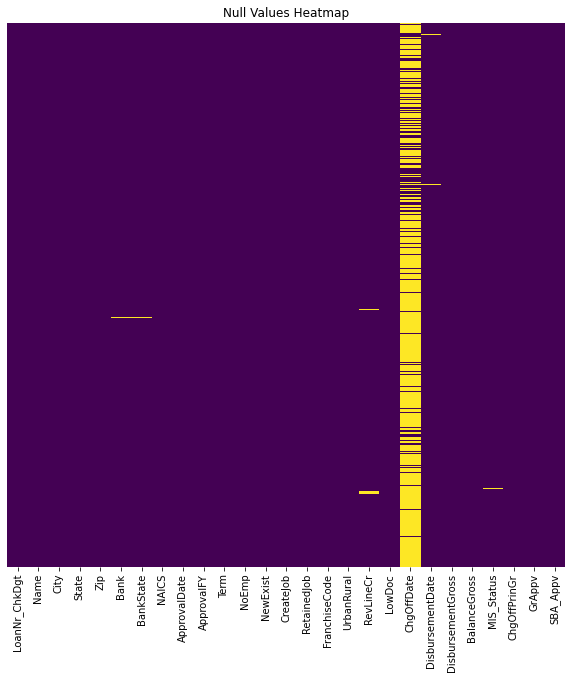

In [7]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Null Values Heatmap')

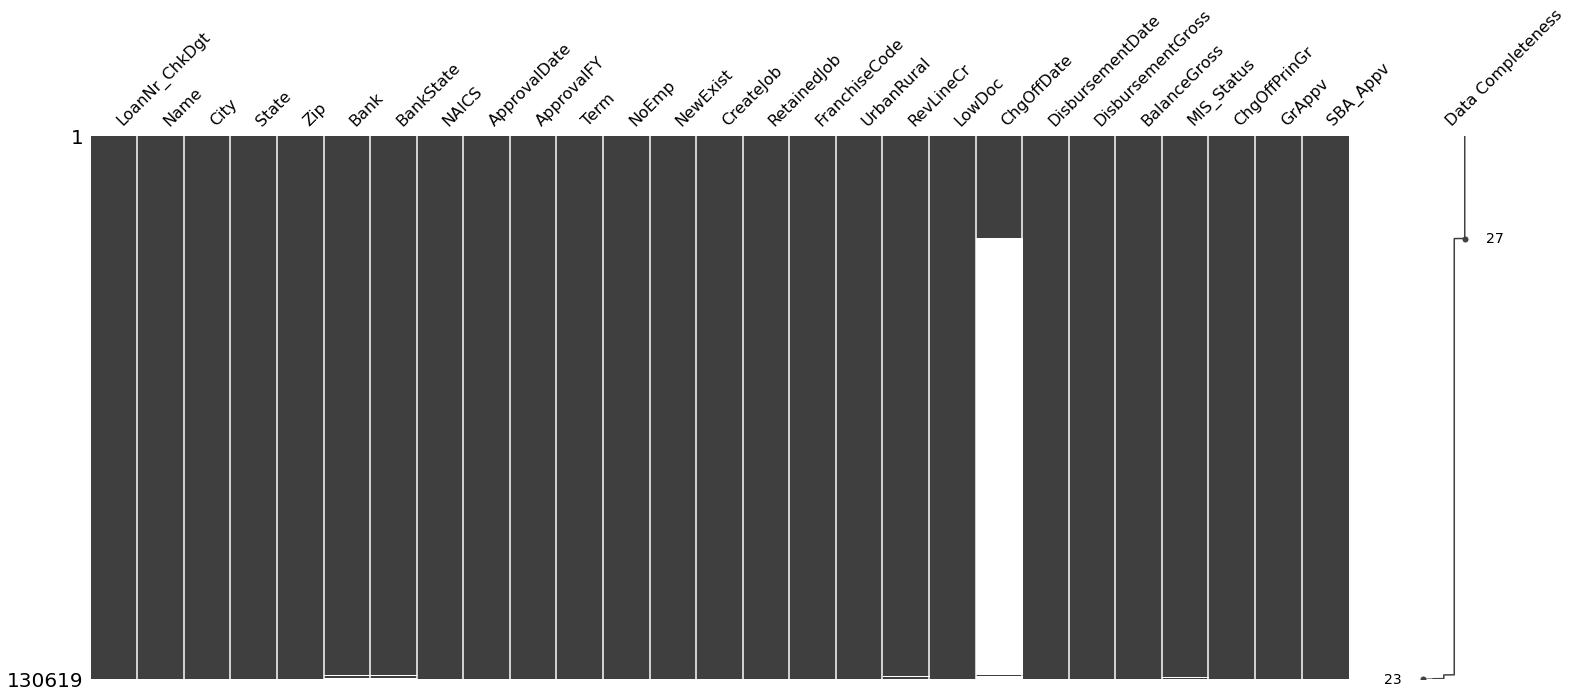

In [8]:
# Missing values by samples
msno.matrix(df, labels = True, sort = "descending");

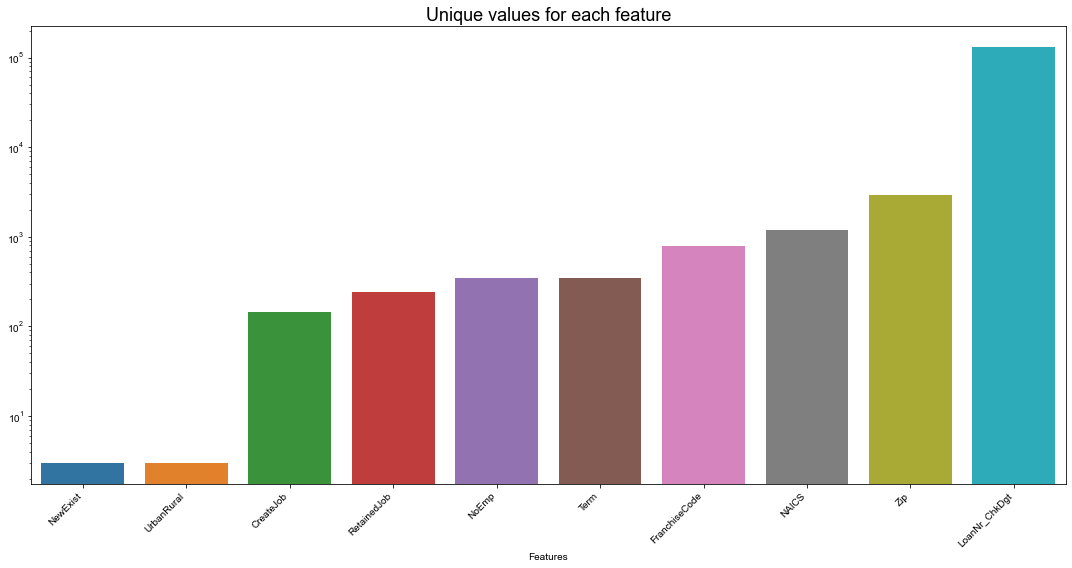

In [9]:
# Unique value by categorical variables
unique_values = df.select_dtypes("number").nunique().sort_values()

fig, ax = plt.subplots(figsize = (15, 8))
sns.barplot(x = unique_values.index, y = unique_values, ax = ax)
sns.set_style("darkgrid")
ax.set_yscale("log")
ax.set_xlabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Unique values for each feature", fontsize = 18)

plt.tight_layout();

In [10]:
# Get Duplicated values
duplicate_value = df.duplicated().sum()
print(f"Duplicated values: {duplicate_value}")

Duplicated values: 0


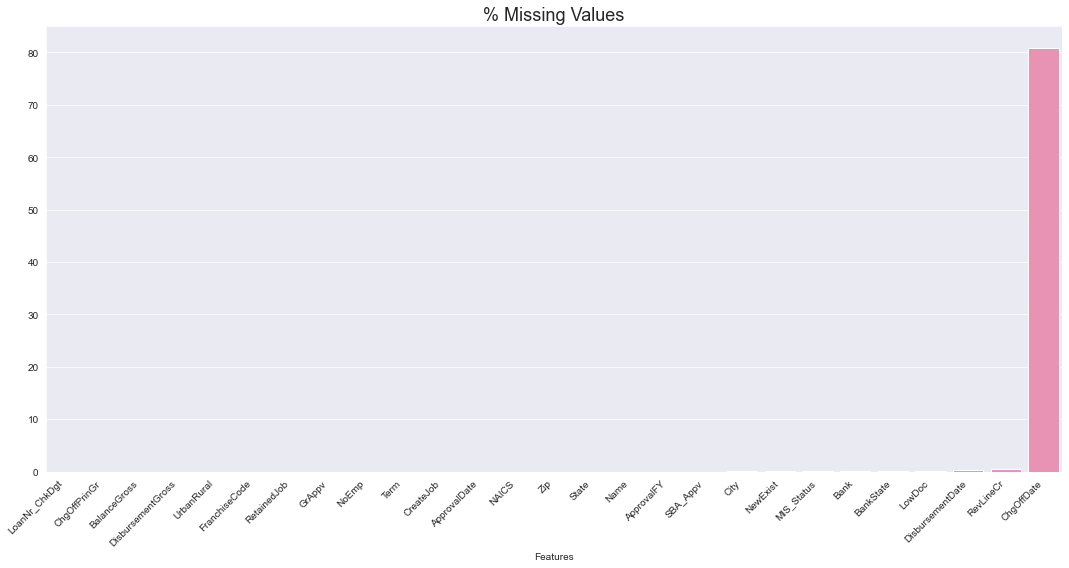

In [11]:
# Percentage Missing vlaues by Features
avg_missing = (df.isnull().mean().sort_values())

fig, ax = plt.subplots(figsize = (15, 8))
sns.barplot(x = avg_missing.index, y = avg_missing*100, ax = ax )
ax.set_xlabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("% Missing Values", fontsize = 18)

plt.tight_layout();

In [12]:
# 
def preprocess_loan_data(df):
    # Create a deep copy of the input DataFrame to avoid modifying the original
    df_cleaned = df.copy(deep=True)
    
    # Clean monetary values: Remove '$' and ',' and convert to float
    money_columns = ['DisbursementGross', 'GrAppv', 'SBA_Appv']
    for col in money_columns:
        df_cleaned[col] = df_cleaned[col].str.strip()
        df_cleaned[col] = df_cleaned[col].str.replace('$', '').str.replace(',', '').astype(float)
        
    # Define a list of unnecessary, inconsistent, or information-leaking variables
    unnecessary_columns = [
        'LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
        'NAICS', 'ApprovalDate', 'NewExist', 'ApprovalFY', 'FranchiseCode',
        'ChgOffPrinGr', 'ChgOffDate', 'BalanceGross', 'RevLineCr', 'LowDoc',
        'CreateJob', 'RetainedJob', 'UrbanRural', 'DisbursementDate', 'DisbursementYear',
        'MIS_Status'
    ]
    
    df_cleaned['NAICS_code'] = df_cleaned['NAICS'].apply(lambda x: str(x)[:2]).astype(int)
    df_cleaned = df_cleaned[df_cleaned['NAICS_code'] >= 11.0]
    
    df_cleaned['New'] = df_cleaned['NewExist'].apply(lambda x: 1 if x == 2.0 else 0)

    # Extract the year part from 'DisbursementDate'
    df_cleaned['DisbursementYear'] = pd.to_datetime(df_cleaned['DisbursementDate']).dt.year

    # Create a binary 'Recession' variable based on 'DisbursementYear'
    df_cleaned['Recession'] = df_cleaned['DisbursementYear'].apply(lambda year: 1 if 2007 <= year <= 2009 else 0)
    
    # Define a list of variables to remove
    unnecessary_columns.append('DisbursementDate')

    # Create a binary 'RealEstate' variable based on 'Term'
    df_cleaned['RealEstate'] = df_cleaned['Term'].apply(lambda term: 1 if term >= 240 else 0)

    # Calculate the SBA's guaranteed portion of the approved loan
    df_cleaned['SBA_Guaranteed_Portion'] = df_cleaned['SBA_Appv'] / df_cleaned['GrAppv']
    

    # Create a binary 'Default' target variable based on 'MIS_Status'
    df_cleaned['Default'] = (df_cleaned['MIS_Status'] == 'CHGOFF').astype(int)

    # Drop unnecessary columns
    df_cleaned.drop(columns=unnecessary_columns, inplace=True)

    # Drop rows with missing values
    df_cleaned.dropna(inplace=True)

    return df_cleaned


In [13]:
df_tran = preprocess_loan_data(df)
print(df_tran.shape)
df_tran.head()

(101918, 11)


,Term,NoEmp,DisbursementGross,GrAppv,SBA_Appv,NAICS_code,New,Recession,RealEstate,SBA_Guaranteed_Portion,Default
28,83,18,438541.0,100000.0,50000.0,61,1,0,0,0.5,0
62,36,20,35000.0,35000.0,17500.0,31,1,0,0,0.5,0
69,84,2,18107.0,20000.0,10000.0,54,0,0,0,0.5,0
70,84,3,10000.0,10000.0,5000.0,81,0,0,0,0.5,0
77,36,18,577000.0,300000.0,150000.0,42,0,0,0,0.5,0


# Exploratory Data Analysis

#### Analysing Recession

In [14]:
# Recession analysis 
# Proportion of loans paid in full during recession
default_recession = pd.DataFrame()
default_recession['Loan Paid in Full'] = (
    df_tran[(df_tran['Default'] == 0) ].groupby('Recession')['Default'].count()/
    df_tran.groupby('Recession')['Default'].count()
)
# Proportion of loans default during recession
default_recession['Loan Default'] = (
    df_tran[(df_tran['Default'] == 1) ].groupby('Recession')['Default'].count()/
    df_tran.groupby('Recession')['Default'].count()
)

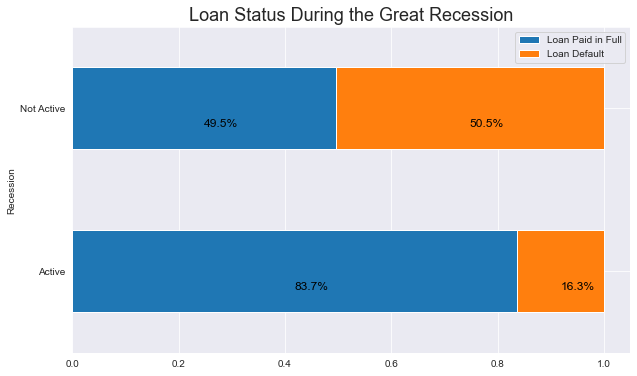

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
default_recession.plot(kind='barh', stacked=True, ax=ax)

# Set plot title and legend
plt.title('Loan Status During the Great Recession', fontsize=18)
plt.legend(loc='upper right')

# Annotate the bars with percentages
for n, category in enumerate(default_recession.index):
    for proportion, y_loc in zip(default_recession.loc[category], default_recession.loc[category].cumsum()):
        # Calculate the x-coordinate for annotation
        x_annotation = (y_loc - proportion) + (proportion / 2)
        
        # Add text annotation to the bars
        plt.text(x=x_annotation,
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12)

# Set y-axis labels
ax.yaxis.set_ticklabels(['Active', 'Not Active'])

# Display the plot
plt.show()

##### **Real Estate**

In [16]:
### Ressecion analysis 
default_real_estate = pd.DataFrame()
## Proportions of loan paid in full during recession
default_real_estate['Loan Paid in Full'] = (
    df_tran[(df_tran['Default'] == 0.0) ].groupby('RealEstate')['Default'].count()/
    df_tran.groupby('RealEstate')['Default'].count()
)
## Proportions of loan default during recession
default_real_estate['Loan Default'] = (
    df_tran[(df_tran['Default'] == 1.0) ].groupby('RealEstate')['Default'].count()/
    df_tran.groupby('RealEstate')['Default'].count()
)

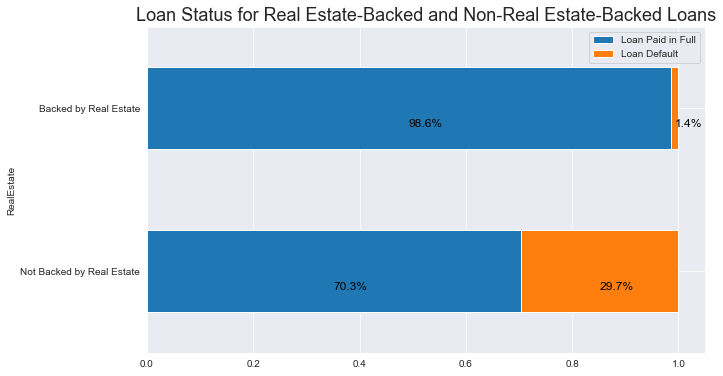

In [18]:
# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
default_real_estate.plot(kind='barh', stacked=True, ax=ax)

# Set plot title and legend
plt.title('Loan Status for Real Estate-Backed and Non-Real Estate-Backed Loans', fontsize=18)
plt.legend(loc='upper right')

# Annotate the bars with percentages
for n, category in enumerate(default_real_estate.index):
    for proportion, y_loc in zip(default_real_estate.loc[category], default_real_estate.loc[category].cumsum()):
        # Calculate the x-coordinate for annotation
        x_annotation = (y_loc - proportion) + (proportion / 2)
        
        # Add text annotation to the bars
        plt.text(x=x_annotation,
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,)

# Set y-axis labels
ax.yaxis.set_ticklabels(['Not Backed by Real Estate', 'Backed by Real Estate'])

# Display the plot
plt.show()


##### **Loan Status**

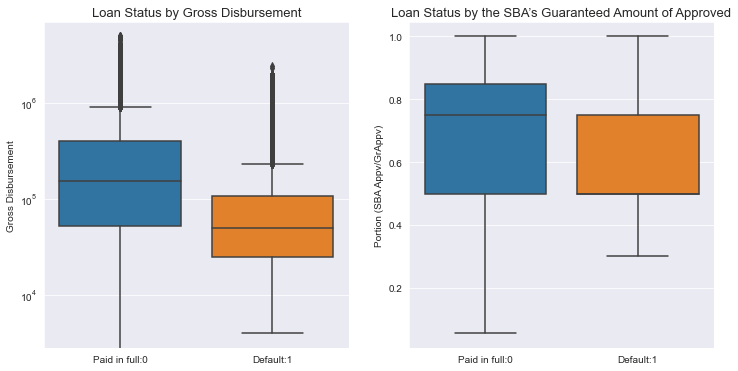

In [19]:
fig = plt.figure(figsize =(12, 6))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Gross Disbursement vs Default plot
sns.boxplot(x=df_tran['Default'], y=df_tran['DisbursementGross'], ax = ax0)
ax0.set_xlabel('')
ax0.set_yscale("log")
ax0.set_ylabel('Gross Disbursement')
ax0.set_title('Loan Status by Gross Disbursement', fontsize = 13)
ax0.xaxis.set_ticklabels(["Paid in full:0", "Default:1"])

# Portion vs Default plot
sns.boxplot(x=df_tran['Default'], y=df_tran['SBA_Guaranteed_Portion'] , ax = ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Portion (SBA Appv/GrAppv)')
ax1.xaxis.set_ticklabels(["Paid in full:0", "Default:1"])
ax1.set_title('Loan Status by the SBA’s Guaranteed Amount of Approved',fontsize = 13);

In [20]:
# Save clean dataset
df_tran.to_csv('data/SBAnational_clean.csv', index= False)

#### Data Visualizations

In [21]:
df_tran.describe().T

,count,mean,std,min,25%,50%,75%,max
Term,101918.0,129.387449,93.637933,0.000,64.0,84.00,240.00,527.0
NoEmp,101918.0,11.892973,64.645983,0.000,2.0,5.00,10.00,8041.0
DisbursementGross,101918.0,259223.004847,351027.681159,0.000,49750.0,120000.00,330000.00,5000000.0
GrAppv,101918.0,251202.443857,352992.400301,1000.000,35000.0,100000.00,322000.00,5000000.0
SBA_Appv,101918.0,197615.237014,292547.196825,500.000,20000.0,75000.00,255750.00,5000000.0
NAICS_code,101918.0,50.859593,16.530128,11.000,42.0,48.00,62.00,92.0
New,101918.0,0.165614,0.371735,0.000,0.0,0.00,0.00,1.0
Recession,101918.0,0.172835,0.378106,0.000,0.0,0.00,0.00,1.0
RealEstate,101918.0,0.265115,0.441397,0.000,0.0,0.00,1.00,1.0
SBA_Guaranteed_Portion,101918.0,0.694890,0.175579,0.056,0.5,0.75,0.85,1.0


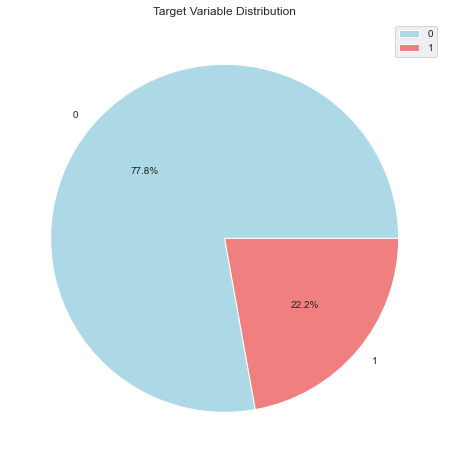

In [22]:
# Target distribution
class_counts = df_tran['Default'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Target Variable Distribution')
plt.legend()
plt.show()

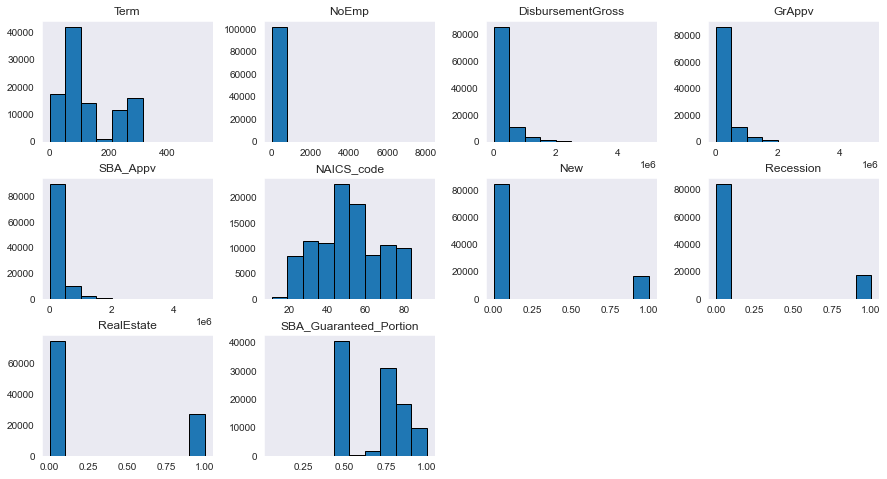

In [23]:
# Feature distributions
df_tran.drop(columns = 'Default').hist(bins = 10,
                                      figsize = (15, 8),
                                      layout = (-1, 4),
                                      grid = False,
                                      edgecolor = "black",
                                      )
plt.title('Feature Distributions')
plt.show()

In [24]:
# Kurtosis and skew
num_features = [colm for colm in df_tran.select_dtypes("number").columns if colm != "Default"]

for col in num_features:
    kurt = scipy.stats.mstats.kurtosis(df_tran[col])
    Skew = scipy.stats.mstats.skew(df_tran[col])
    
    print(f"{col} Skew: {np.round(Skew, 2)}, Kurtosis: {np.round(kurt, 2)}")

Term Skew: 0.8, Kurtosis: -0.81
NoEmp Skew: 75.78, Kurtosis: 7420.26
DisbursementGross Skew: 2.86, Kurtosis: 13.27
GrAppv Skew: 2.81, Kurtosis: 12.46
SBA_Appv Skew: 2.99, Kurtosis: 15.55
NAICS_code Skew: 0.21, Kurtosis: -0.63
New Skew: 1.8, Kurtosis: 1.24
Recession Skew: 1.73, Kurtosis: 0.99
RealEstate Skew: 1.06, Kurtosis: -0.87
SBA_Guaranteed_Portion Skew: 0.13, Kurtosis: -1.3


In [25]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101918 entries, 28 to 899161
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Term                    101918 non-null  int64  
 1   NoEmp                   101918 non-null  int64  
 2   DisbursementGross       101918 non-null  float64
 3   GrAppv                  101918 non-null  float64
 4   SBA_Appv                101918 non-null  float64
 5   NAICS_code              101918 non-null  int32  
 6   New                     101918 non-null  int64  
 7   Recession               101918 non-null  int64  
 8   RealEstate              101918 non-null  int64  
 9   SBA_Guaranteed_Portion  101918 non-null  float64
 10  Default                 101918 non-null  int32  
dtypes: float64(4), int32(2), int64(5)
memory usage: 8.6 MB


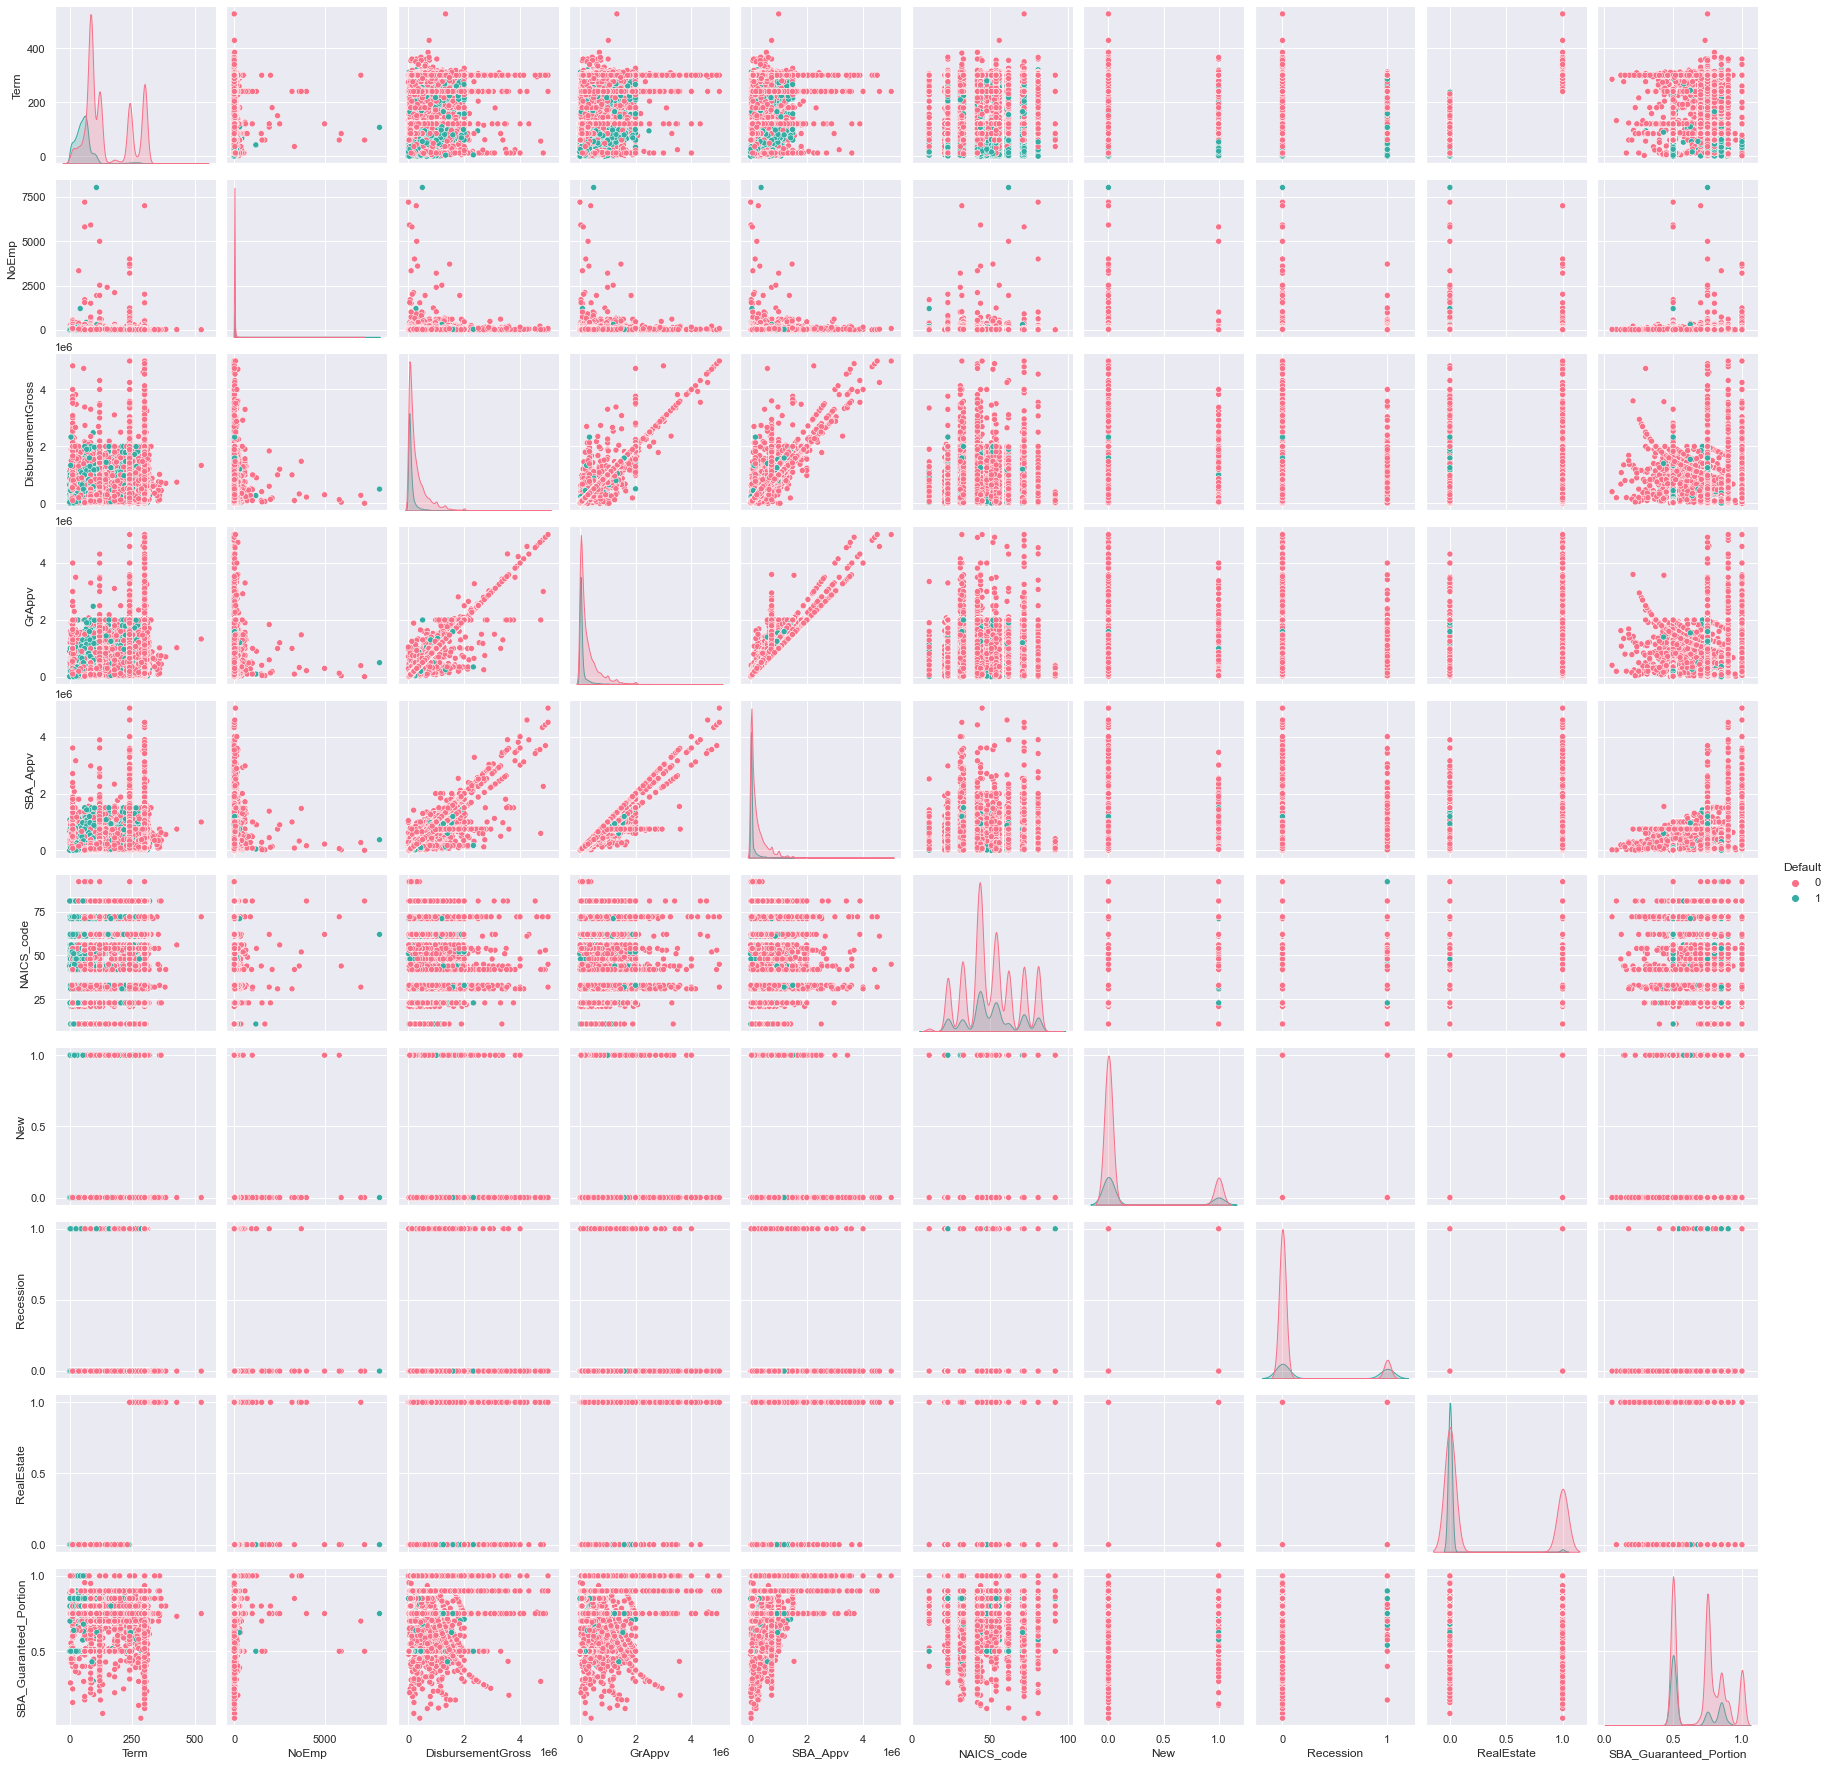

In [26]:
## pairplot
sns.set(rc={'figure.figsize':(14,8)})
sns.pairplot(df_tran, hue='Default', palette='husl')
sns.set_context('talk')
sns.set_style('white')

In [27]:
# Correlation
pearson_corr = df_tran.corr(method = 'pearson')
spearman_corr = df_tran.corr(method = 'spearman')

<AxesSubplot:>

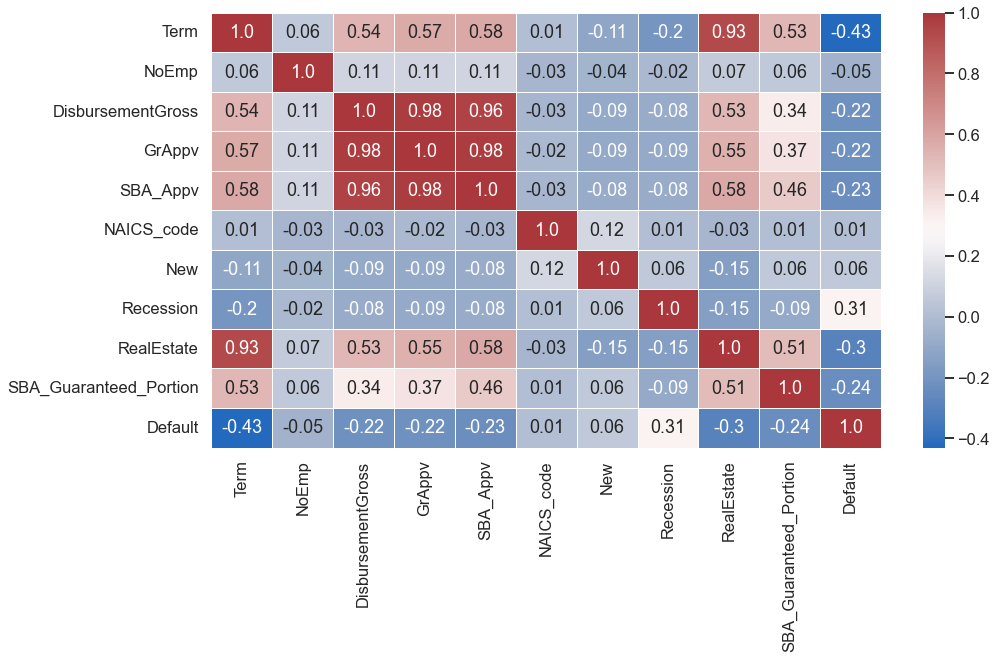

In [28]:
# Pearson's Correlation plot
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(np.round(pearson_corr, 2),
              annot = True, fmt = "", linewidths = .5,cmap ="vlag", ax = ax)

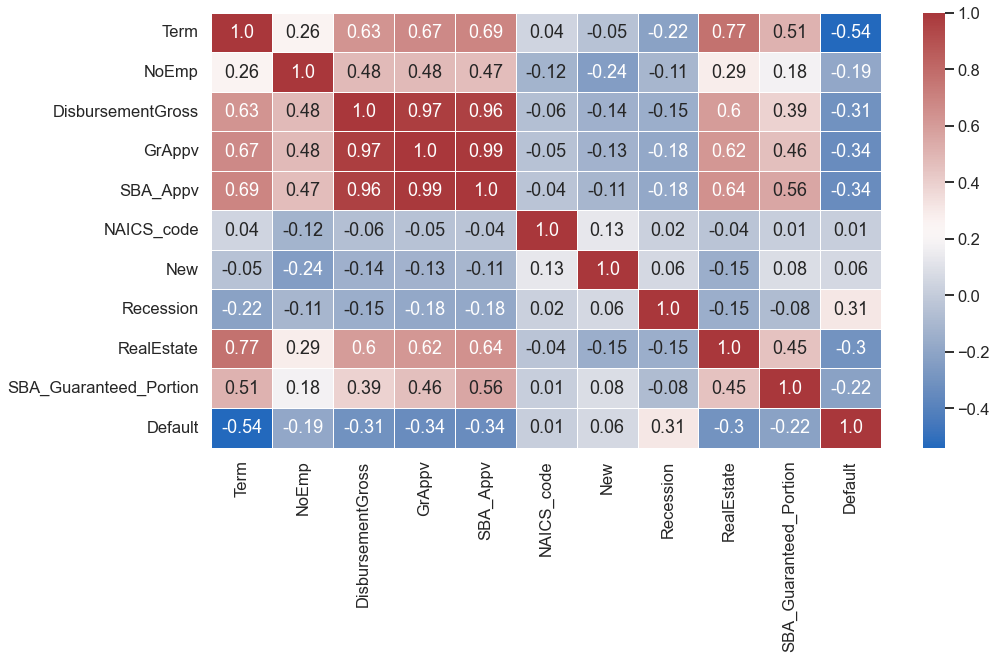

In [29]:
# Spearman's Correlation plot
fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(np.round(spearman_corr, 2), square = False,
              annot = True, fmt = "", linewidths = .5,cmap ="vlag", ax = ax)

# Training

#### Train-Test-Validation Split


In [30]:
# Split data into Features and target 
target = 'Default'
X = df_tran.drop(columns = target)
y = df_tran[target]


print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (101918, 10)
Labels shape: (101918,)


In [34]:
# split the data into train, val and test set
def train_test_val_split(features, labels, split_train, split_val):

  # Split and get index
  train_idx_f, test_idx = next(split_train.split(features, labels))

  # first x and y train set
  X_train_f = features.iloc[train_idx_f]
  y_train_f = labels.iloc[train_idx_f]

  # X and y test set
  X_test = features.iloc[test_idx]
  y_test = labels.iloc[test_idx]

  # Second Split and get index
  train_idx, val_idx = next(split_val.split(X_train_f, y_train_f))

  # X and y train set (definitive)
  X_train = features.iloc[train_idx]
  y_train = labels.iloc[train_idx]

  # X and y validation set
  X_val = features.iloc[val_idx]
  y_val = labels.iloc[val_idx]

  return X_train, y_train, X_test, y_test, X_val, y_val

In [36]:
split_train = StratifiedShuffleSplit(n_splits = 1,
                                     test_size = 0.1,
                                     random_state = np.random.seed(42)
                                     )
split_val = StratifiedShuffleSplit(n_splits = 1,
                                     test_size = 0.1,
                                     random_state = np.random.seed(42)
                                     )

X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(X, y, split_train, split_val)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (82553, 10)
X_val shape:(9173, 10)
X_test shape:(10192, 10)
y_train shape: (82553,)
y_val shape: (9173,)
y_test shape: (10192,)


#### Resolving Data Imbalance

In [37]:
# OverSampling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
def oversampling(alg, X, y):
    
    alg_over = alg(random_state = np.random.seed(42), n_jobs = -1)
  
    X_train_over, y_train_over = alg_over.fit_resample(X, y)
    
    return X_train_over, y_train_over

In [39]:
X_train, y_train = oversampling(BorderlineSMOTE, X_train, y_train) 

print(f"X train oversampled shape: {X_train.shape}")
print(f"y train oversampled shape: {y_train.shape}")

X train oversampled shape: (127250, 10)
y train oversampled shape: (127250,)


#### Modelling


In [40]:
# Model Performance
from sklearn.metrics import log_loss
dict_df = {
    'Model':['Baseline', 'RandomForest', 'ExtraTrees', 'XGBoost'],
    'Log Loss':[0,0,0,0],
    'Accuracy':[0,0,0,0],
    'Precision':[0,0,0,0],
    'Recall':[0,0,0,0],
    'F1-Score':[0,0,0,0],
    'AUC':[0,0,0,0]
}

df_result = pd.DataFrame(dict_df, columns = ['Model','Log Loss','Accuracy', 'Precision', 'Recall','F1-Score','AUC'])

def model_results(model, y_val, y_pred):
  
  inx_models = df_result[df_result['Model'] == model].index

  df_result.loc[inx_models, 'Log Loss'] = log_loss(y_val, y_pred)
  df_result.loc[inx_models, 'Accuracy'] = accuracy_score(y_val, y_pred)
  df_result.loc[inx_models, 'Precision'] = precision_score(y_val, y_pred)
  df_result.loc[inx_models, 'Recall'] = recall_score(y_val, y_pred)
  df_result.loc[inx_models, 'F1-Score'] = f1_score(y_val, y_pred)
  df_result.loc[inx_models, 'AUC'] = roc_auc_score(y_val, y_pred)

  return (df_result)

#Funtion: performance of the model with the validation set
def model_performance_test(y_test, y_pred, y_pred_pro):
  ## Accuracy and roc_auc score
  print(f"Accuracy: {accuracy_score(y_test, y_pred)} \nRoc_Auc score: {roc_auc_score(y_test, y_pred)}\nF1-score: {f1_score(y_test, y_pred)}")

  ## Roc curve
  fpr, tpr, thr = roc_curve(y_test, y_pred_pro[:,1])
  
  ## define the figure and its size
  plt.figure(figsize =(15,5))
  layout = (1,2)
  
  # Axis
  cmd = plt.subplot2grid(layout,(0,0))
  rc = plt.subplot2grid(layout,(0,1))
  
  # Conision Matrix plot 
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = cmd)
  cmd.xaxis.set_ticklabels(["Not fraud:0", "Fraud:1"])
  cmd.yaxis.set_ticklabels(["Not fraud:0", "Fraud:1"])
  
  # Roc-Auc Curve plot
  rc.plot(fpr, tpr, color ='blue', linewidth = 5)
  rc.plot([0, 1],[0, 1], ls = '--', color = 'red', lw = .4)
  rc.set(xlabel = 'False Positive Rate',
       ylabel = 'True Positive Rate',
       xlim =[-.01, 1.01], ylim =[-.01, 1.01],
       title = 'ROC curve')
  
  plt.show()

#### Baseline Model

In [41]:
# LogisticRegression model
lr_model = LogisticRegression()

# Fit the model
lr_model.fit(X_train,y_train)

LogisticRegression()

In [42]:
bs_pred = lr_model.predict(X_val)
model_results('Baseline', y_val, bs_pred)

,Model,Log Loss,Accuracy,Precision,Recall,F1-Score,AUC
0,Baseline,8.246082,0.761256,0.491377,0.788832,0.605548,0.770871
1,RandomForest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ExtraTrees,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### RandomForest Model

In [43]:
## RandomForest 
model_rf = RandomForestClassifier(
  #  n_estimators = 1000,
  #  max_depth = 10,
#   criterion = 'entropy',
 #   class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
)

model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [44]:
## model performance 
acc_train_rf = model_rf.score(X_train, y_train)
acc_val_rf = model_rf.score(X_val, y_val)

print(f"RandomForest Train Accuracy:{round(acc_train_rf,2)} \nRandomForest Validation Accuracy: {round(acc_val_rf,2)}")

RandomForest Train Accuracy:1.0 
RandomForest Validation Accuracy: 0.94


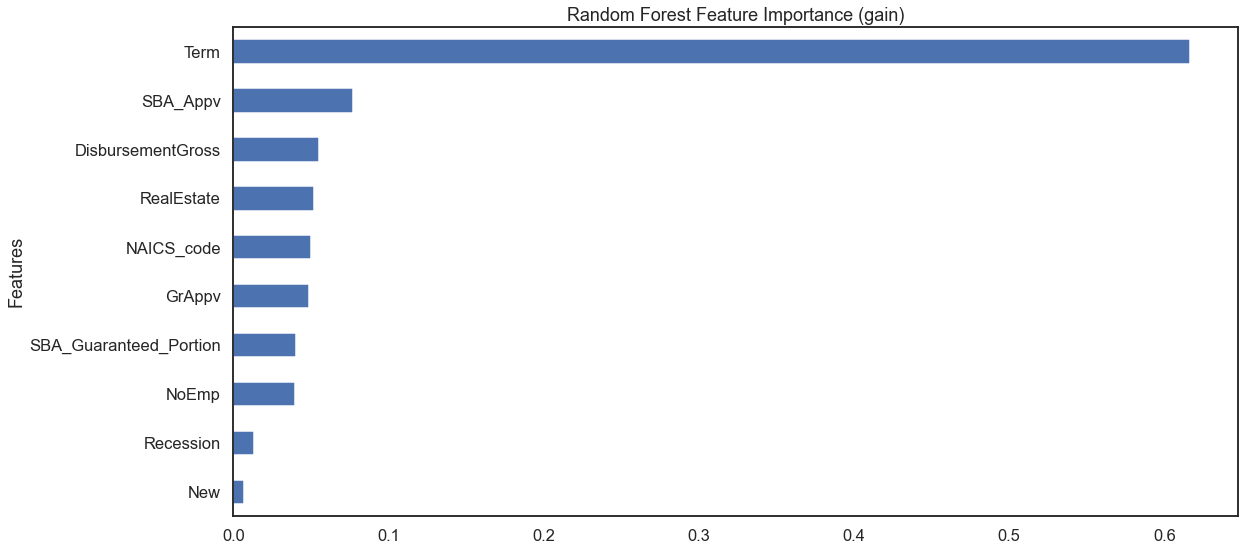

In [46]:
# RandomForest Feature importance
fea_imp_rf = pd.Series(model_rf.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_rf.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance (gain)', fontsize = 18);

In [47]:
# RandomForest Classification report with the validation set
y_pred_rf = model_rf.predict(X_val)

model_results('RandomForest', y_val, y_pred_rf)

,Model,Log Loss,Accuracy,Precision,Recall,F1-Score,AUC
0,Baseline,8.246082,0.761256,0.491377,0.788832,0.605548,0.770871
1,RandomForest,2.074696,0.939932,0.832212,0.928672,0.877800,0.936006
2,ExtraTrees,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### ExtraTrees Model

In [48]:
extree_model = ExtraTreesClassifier(
#    n_estimators = 1000,
#    max_depth = 10,
#    criterion = 'entropy',
#    class_weight = 'balanced',
#    random_state = 100,
#    n_jobs = -1
)
extree_model.fit(X_train, y_train)

ExtraTreesClassifier()

In [49]:
# model performance 
acc_train_et = extree_model.score(X_train, y_train)
acc_val_et = extree_model.score(X_val, y_val)

print(f"ExtraTrees  Train Accuracy:{round(acc_train_et,2)} \nExtraTrees Validation Accuracy: {round(acc_val_et,2)}")

ExtraTrees  Train Accuracy:1.0 
ExtraTrees Validation Accuracy: 0.93


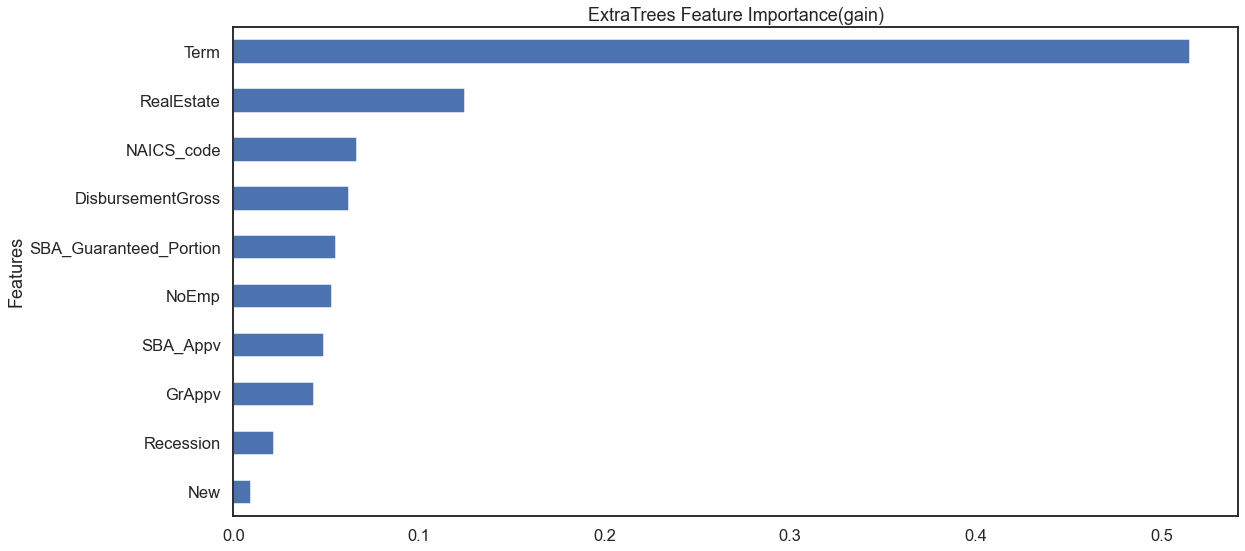

In [50]:
# ExtraTrees Feature importance
fea_imp_et = pd.Series(extree_model.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_et.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('ExtraTrees Feature Importance(gain)', fontsize = 18);

In [51]:
# Extratree model performnace
y_pred_et = extree_model.predict(X_val)

model_results('ExtraTrees', y_val, y_pred_et)

,Model,Log Loss,Accuracy,Precision,Recall,F1-Score,AUC
0,Baseline,8.246082,0.761256,0.491377,0.788832,0.605548,0.770871
1,RandomForest,2.074696,0.939932,0.832212,0.928672,0.877800,0.936006
2,ExtraTrees,2.357094,0.931756,0.817645,0.908963,0.860889,0.923808
3,XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### XGBoost Model

In [52]:
# XGBClassifier
model_xgb = xgb.XGBClassifier(seed = 42)

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [53]:
## Model performance with the train a validation set
acc_train_xgb = model_xgb.score(X_train, y_train)
acc_val_xgb = model_xgb.score(X_val, y_val)

print(f"XGB Train Accuracy:{round(acc_train_xgb,2)} \nXGB Validation Accuracy: {round(acc_val_xgb,2)}")

XGB Train Accuracy:0.96 
XGB Validation Accuracy: 0.95


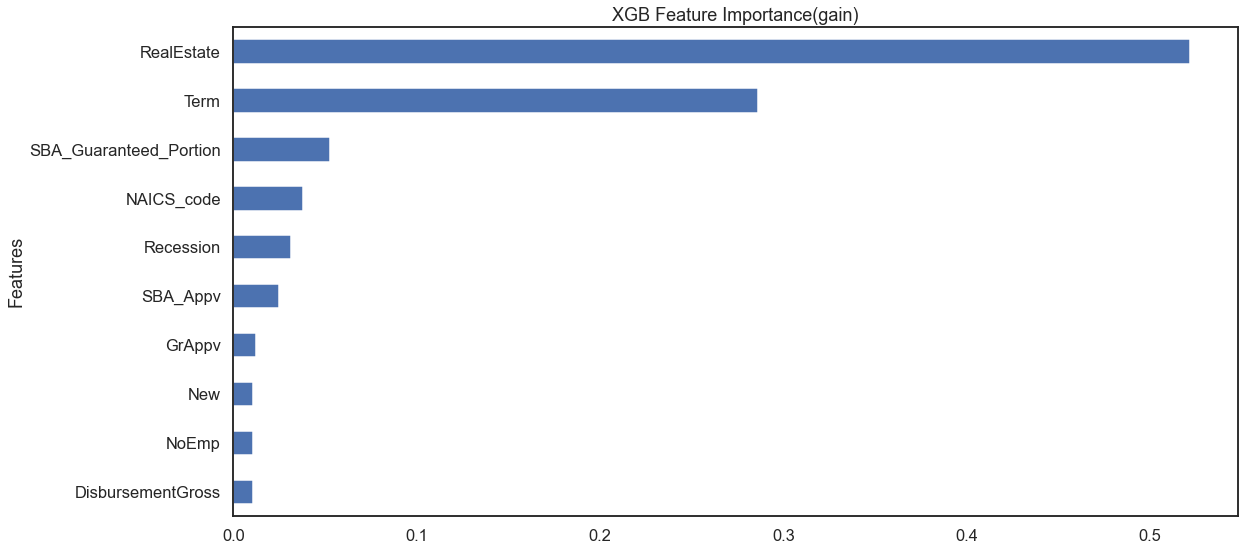

In [55]:
# Feature importance
fea_imp_xgb = pd.Series(model_xgb.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_xgb.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Feature Importance(gain)', fontsize = 18);

In [56]:
# Xgb Classification report with the validation set
y_pred_xgb = model_xgb.predict(X_val)

model_results('XGBoost', y_val, y_pred_xgb)

,Model,Log Loss,Accuracy,Precision,Recall,F1-Score,AUC
0,Baseline,8.246082,0.761256,0.491377,0.788832,0.605548,0.770871
1,RandomForest,2.074696,0.939932,0.832212,0.928672,0.877800,0.936006
2,ExtraTrees,2.357094,0.931756,0.817645,0.908963,0.860889,0.923808
3,XGBoost,1.739581,0.949635,0.858925,0.937119,0.896320,0.945271


#### Hyperparameters Tuning (Best Model: XGBoost)

In [57]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score

# Number of folder to split the training data
strkf = StratifiedKFold(n_splits = 4)

# Space of hyperparameters
space = {
         'tree_method':'gpu_hist',
         'objective': 'binary:logistic',
         'subsample': hp.uniform('subsample', 0.5, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
         'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
         'learning_rate': hp.loguniform('learning_rate', -8, 0),
         'min_child_weight': hp.quniform('min_child_weight',3, 10, 1),
         'max_depth': scope.int(hp.uniform('max_depth', 6, 20)),
         'gamma': hp.loguniform('gamma', -10, 3),
         'reg_alpha': hp.loguniform('alpha', -10, 2),
         'reg_lambda': hp.loguniform('reg_lambda', -10, 2),
         'n_estimators': scope.int(hp.uniform('n_estimators', 100, 500)),
         'seed': 42, 
         
    }


def objective(param):
  model = xgb.XGBClassifier(**param)
  roc_auc = cross_val_score(model, X_train, y_train, scoring = "roc_auc", cv = strkf).mean() 
  return {'loss': -roc_auc, 'status': STATUS_OK }

    
trials = Trials()

best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 70,
            trials = trials,)
print(best)

100%|██████████| 70/70 [14:13<00:00, 12.20s/trial, best loss: -0.9898233642418699]
{'alpha': 0.00010344809888653869, 'colsample_bylevel': 0.75733552643106, 'colsample_bytree': 0.5034158616666615, 'gamma': 0.09597903522528049, 'learning_rate': 0.1010306115150487, 'max_depth': 19.462314125050103, 'min_child_weight': 3.0, 'n_estimators': 139.70468238904633, 'reg_lambda': 0.7408593101524926, 'subsample': 0.9800581247668694}


#### Final Model

In [58]:
# Train final model
final_model = xgb.XGBClassifier(
    tree_method = 'gpu_hist',
    objective = 'binary:logistic',
    learning_rate = best['learning_rate'],
    max_depth = int(best['max_depth']),
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    colsample_bylevel = best['colsample_bylevel'],
    min_child_weight = int(best['min_child_weight']),
    reg_lambda = best['reg_lambda'],
    reg_alpha = best['alpha'],
    gamma = int(best['gamma']),
    n_estimators = int(best['n_estimators']),
    seed = 42)

final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.75733552643106, colsample_bynode=None,
              colsample_bytree=0.5034158616666615, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1010306115150487,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=139, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Evaluation

#### Predictions

In [59]:
y_pred = final_model.predict(X_test)
y_pred_pro = final_model.predict_proba(X_test)

#### Model Performance

Accuracy: 0.9673273155416012 
Roc_Auc score: 0.9450112053860054
F1-score: 0.928402494087293


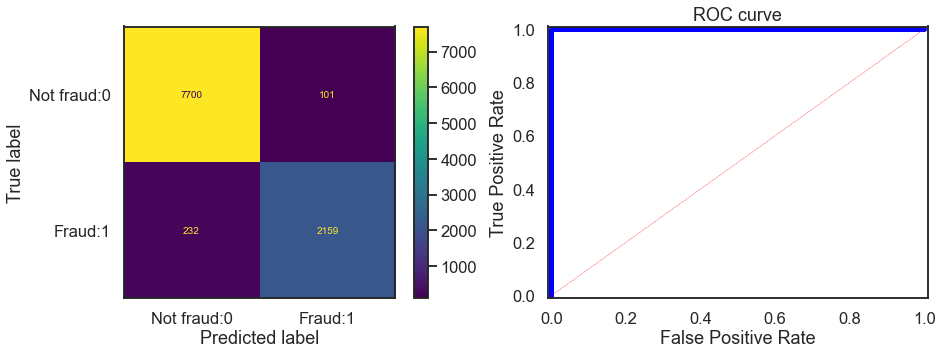

In [60]:
# Final model performance
model_performance_test(y_pred, y_test, y_pred_pro)

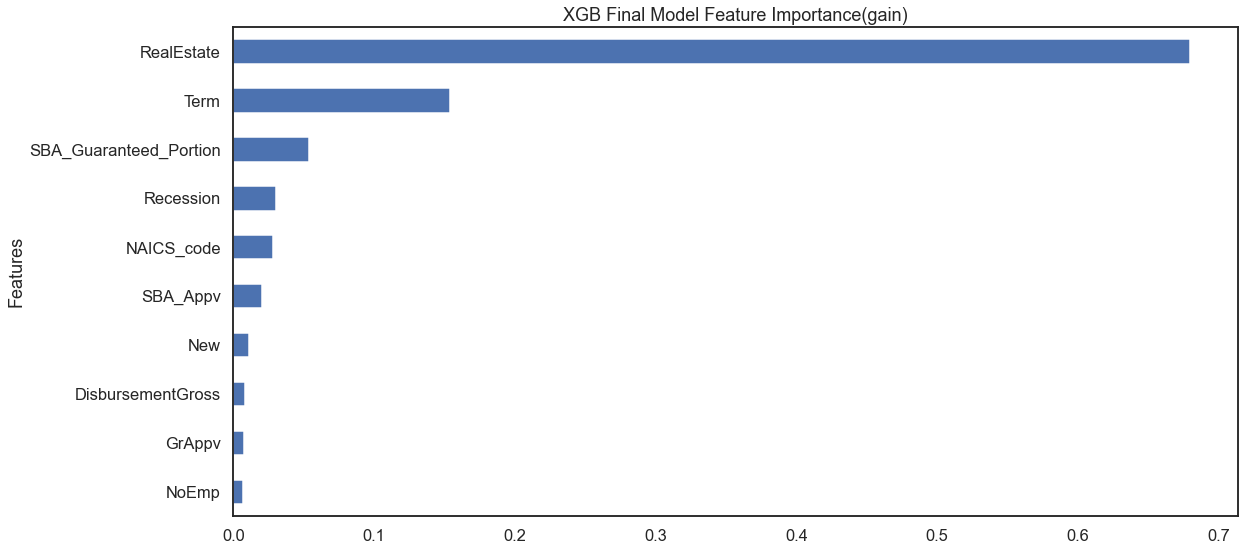

In [61]:
# Feature importance
fea_imp_xgb_h = pd.Series(final_model.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_xgb_h.sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Final Model Feature Importance(gain)', fontsize = 18);

# Save Model

In [62]:
with open('models/XGB-v1.pkl', 'wb') as f:
  joblib.dump(final_model, f)